In [1]:
import os
import sys
import ast
import cv2
import json
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.append('./')
from utils import normalize_image, plot_image, plot_images

In [4]:
# root_dir = '/data/jupiter/datasets/Jupiter_train_v5_11'
root_dir = '/data/jupiter/datasets/Jupiter_train_v5_11_20230508'
# root_dir = '/data/jupiter/datasets/Jupiter_20230801_20231011_stop_event_labeling_candidates'
# root_dir = '/data/jupiter/datasets/Jupiter_train5_11_driveable_not_labeled_on_harvest'
# root_dir = '/data/jupiter/datasets/Jupiter_halo_labeled_data_20230427_stereo_640'
# root_dir = '/data/jupiter/datasets/Jupiter_halo_labeled_data_20230427_stereo_768'
# root_dir = '/data/jupiter/datasets/20230823_labeled_right_images_12k'
# root_dir = '/data/jupiter/li.yu/data/Jupiter_2023_04_05_loamy869_dust_collection_stereo'
# root_dir = '/data/jupiter/li.yu/data/left_and_right_labels_samples'
# root_dir = '/data/jupiter/li.yu/data/Jupiter_2022_Dust_Humans_Unfiltered_partiallabeled'
csv = os.path.join(root_dir, '642ba9506651c8d5688518e0_master_annotations_ppcutnpastecolumns.csv')
# csv = os.path.join(root_dir, 'cache/cutnpaste_presampling_1980823482.csv')
converters = {"label_map": json.loads, "label_counts": ast.literal_eval}
df = pd.read_csv(csv, converters=converters)
df.shape

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (6,7,12,39,112,113,115,133,139,140,144,191,217,218,247,248,278) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(319902, 302)

(319902, 302)

In [5]:
safety_csv = '/data/jupiter/datasets/humans_on_path_test_set_2023_v15_anno/master_annotations.csv'
safety_df = pd.read_csv(safety_csv)
print(safety_df.shape)
overlap_df = df[df.id.isin(safety_df.id)]
print(overlap_df.shape)

(19846, 234)
(99, 302)


/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (92,93,157,210) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
# v4.53
df_v453 = pd.read_csv('/data/jupiter/li.yu/data/xxx/Jupiter_train_v4_53/v453_iq.csv')
print(df_v453.shape)
print('v4.53 overlap: ', len(df_v453[df_v453.image_id.isin(safety_df.id)]))
# v4.71
df_v471 = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v4_71/v471_iq.csv')
print(df_v471.shape)
print('v4.71 overlap: ', len(df_v471[df_v471.image_id.isin(safety_df.id)]))
# v5.5
df_v55 = pd.read_csv('/data/jupiter/li.yu/data/xxx/Jupiter_train_v5_5_devised/train_humanaug_dp.csv')
print(df_v55.shape)
print('v5.5 overlap: ', len(df_v55[df_v55.image_id.isin(safety_df.id)]))
# v5.8
df_v58 = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v5_8/epoch0_5_30_focal05_master_annotations_ppcolumns.csv')
print(df_v58.shape)
print('v5.8 overlap: ', len(df_v58[df_v58.image_id.isin(safety_df.id)]))

(181879, 3)
v4.53 overlap:  51
(195289, 11)
v4.71 overlap:  52


/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (6,7,12,39,109,110,112,116,117,130,136,143,186,202,211,274) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(261640, 293)
v5.5 overlap:  96


/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (6,7,12,39,95,98,110,112,113,115,133,139,191,217,218,247,248,278) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(304896, 302)
v5.8 overlap:  99


In [23]:
safety_v6_df = pd.read_csv('/data/jupiter/li.yu/data/xxx/critical_safety_2022_v6_anno/annotations.csv')
print(safety_v6_df.shape)
print('overlap', len(df_v453[df_v453.image_id.isin(safety_v6_df.id)]))

(39112, 165)
overlap 39


In [10]:
# pd.set_option('display.max_rows', None)
# overlap_df = overlap_df.sort_values('collected_on')
overlap_df[['id', 'collected_on', 'special_notes']]

,id,collected_on,special_notes
202381,6152d0c5235f23c3420e3276,2021-09-22T23:45:11.964000,NaN
259415,6153095232272a54eda0e77f,2021-09-23T23:42:23.016000,NaN
16434,6166f072321a6fce999a7478,2021-10-04T23:39:09.896000,NaN
38458,6166e8e67d2f483b598d6aee,2021-10-04T23:42:16.151000,NaN
9343,616650f0321a6fce99975c0f,2021-10-05T23:36:31.020000,NaN
157768,616fb84c4689c0dd790337a3,2021-10-13T21:56:06.864000,NaN
175514,61817862863dbc4d54dbd334,2021-10-19T23:48:57.906000,Jamall Balentine Static
99410,618192f06667ce0b88cebd0c,2021-10-21T22:56:41.409000,William Sandous Static
222507,6181961f1fa0938ba4dafbc9,2021-10-21T22:56:44.018000,William Sandous Static
275240,61a69ef2311ca26630ac00af,2021-11-01T20:25:21.231000,Jason Bennett Static


### Load label count file

In [5]:
# load label count file
label_count_file = '/data/jupiter/li.yu/exps/driveable_terrain_model/v53_4cls_tversky001_imgaug_60p_0209/Jupiter_train_v5_11/output.csv'
label_count_df = pd.read_csv(label_count_file)
df = df.merge(label_count_df, on='id')
df.shape

(319918, 299)

In [6]:
label_count_df.head()

,id,Driveable,Non-driveable,Trees_Weeds,Sky,Vehicles,Humans,Implement,Dust-and-light-artifacts,Dust,Light-artifacts,Birds,Airborne-debris,Object-lights,Hue,Saturation,Value
0,614d0eb90f7787d7ba7d1e43,524288,0,0,0,0,0,0,0,0,0,0,0,0,250.333240,0.232347,0.613459
1,614d0eb37585e5bf211d83dc,502579,0,0,0,0,21709,0,0,0,0,0,0,0,232.881150,0.260314,0.566149
2,5f6a93e822ff3085e422c43b,188011,0,336277,0,0,0,0,0,0,0,0,0,0,72.015564,0.192680,0.235280
3,6281edf49337b37a8b73baff,356540,2536,0,165193,0,0,0,0,0,0,0,0,19,94.248540,0.128789,0.367974
4,63cf5a656905536c17cedc95,330807,186,4806,188489,0,0,0,0,0,0,0,0,0,215.264850,0.206603,0.581566


In [7]:
# df['labeled_pixels'] = df.apply(lambda r: sum(r[c] for c in ['Driveable', 'Non-driveable', 'Trees_Weeds', 'Sky', 
#                                 'Vehicles', 'Humans', 'Implement', 'Dust-and-light-artifacts', 'Dust', 'Light-artifacts', 
#                                 'Birds', 'Airborne-debris', 'Object-lights']), axis=1)
wdf = df[(df.labeled_pixels < 512*1024//2) | (df.Driveable == 0)]
print(wdf.shape)
# wdf[['id']].to_csv(os.path.join(root_dir, 'less_than_half_labeled.csv'), index=False)

(2628, 300)


In [11]:
label_df1 = pd.read_csv('/data/jupiter/li.yu/exps/driveable_terrain_model/v53_4cls_tversky001_imgaug_60p_0209/Jupiter_train5_11_driveable_not_labeled_on_harvest/output.csv')
label_df2 = pd.read_csv('/data/jupiter/li.yu/exps/driveable_terrain_model/v53_4cls_tversky001_imgaug_60p_0209/Jupiter_train5_11_less_than_half_labeled/output.csv')
label_df1['labeled_pixels'] = label_df1.apply(lambda r: sum(r[c] for c in ['Driveable', 'Non-driveable', 'Trees_Weeds', 'Sky', 
                                'Vehicles', 'Humans', 'Implement', 'Dust-and-light-artifacts', 'Dust', 'Light-artifacts', 
                                'Birds', 'Airborne-debris', 'Object-lights']), axis=1)
label_df2['labeled_pixels'] = label_df2.apply(lambda r: sum(r[c] for c in ['Driveable', 'Non-driveable', 'Trees_Weeds', 'Sky', 
                                'Vehicles', 'Humans', 'Implement', 'Dust-and-light-artifacts', 'Dust', 'Light-artifacts', 
                                'Birds', 'Airborne-debris', 'Object-lights']), axis=1)

print(label_df1.shape, label_df2.shape)
gdf = pd.concat([label_df1[(label_df1.labeled_pixels >= 512*1024//2) & (label_df1.Driveable > 0)], 
                label_df2[(label_df2.labeled_pixels >= 512*1024//2) & (label_df2.Driveable > 0)]], ignore_index=True)
gdf.shape

(2061, 18) (2511, 18)


(2889, 18)

In [17]:
bdf = wdf[~wdf.id.isin(gdf.id)]
print(bdf.shape)
bdf[['id']].to_csv(os.path.join(root_dir, 'less_than_half_or_driveable_not_labeled_for_relabeling.csv'), index=False)

(980, 300)


In [151]:
# vdf = df[(df.Vehicles > 0) & (df['Object-lights'] > 0)]  # images with both vehicles and object lights
# vdf = df[(df.Vehicles > 3000) & (df.operation_time == 'nightime')]  # useful night vehicles
vdf = df[(df.Vehicles > 0) & (df.Vehicles < 100)]  # undersample tiny vehicles
vdf = df[(df['Airborne-debris'] > 10000) & (df['Airborne-debris'] < 100000)]  # oversample airborne debris
print(vdf.shape)
# vdf['Airborne-debris'].hist(bins=100)
# plt.show()

(1149, 300)


In [5]:
pred_df = pd.read_csv('/data/jupiter/li.yu/exps/driveable_terrain_model/v57rd_4cls_tiny0occluded5reverse5triangle5_msml_0305/Jupiter_2022_Dust_Humans_Unfiltered_partiallabeled_epoch43/output.csv')
print(pred_df.shape)
df = df.merge(pred_df[['id', 'state']], on='id')
print(df.shape)

(1365, 11)
(1365, 164)


6520491cee1ec5b92f370e64 unknown 2023-10-03T18:03:24.288000


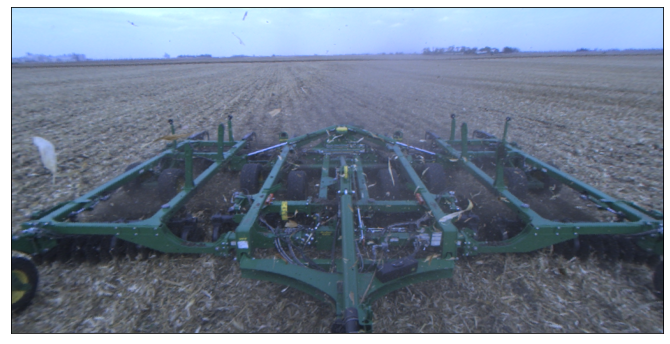

6520491cee1ec5b92f370e64 {'unlabelled': 18685, 'Untilled field': 254297, 'Trees': 3350, 'Sky': 73682, 'Immovable Objects': 2077, 'implement': 163657, 'Airborne Debris': 8540} ['Untilled field', 'Trees', 'Sky', 'Immovable Objects', 'implement', 'Airborne Debris'] [ 0  2  6  7  8 14 25] [ 18685 254297   3350  73682   2077 163657   8540]


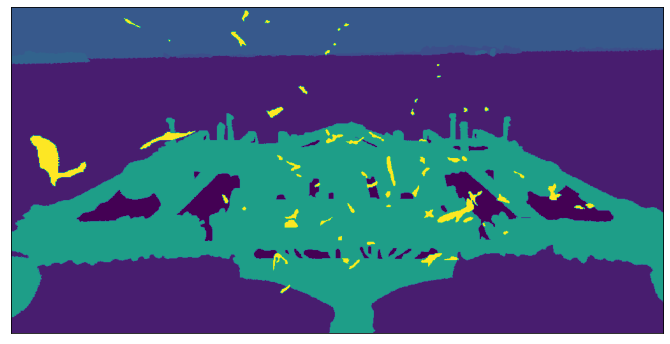

6519f6b39177a677909c91a0 unknown 2023-09-29T18:28:22.315000


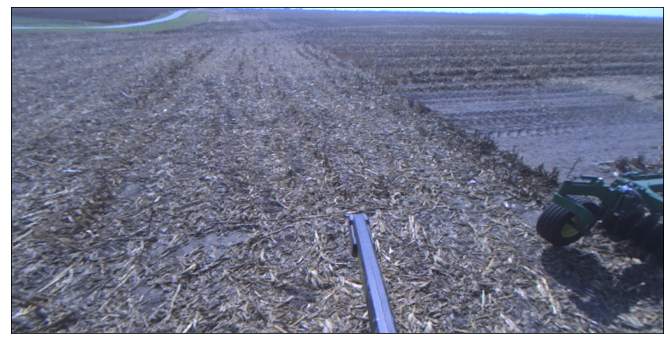

6519f6b39177a677909c91a0 {'unlabelled': 102, 'Untilled field': 488446, 'Road': 1538, 'Utility pole': 83, 'Trees': 2524, 'Sky': 5303, 'Immovable Objects': 116, 'implement': 19227, 'Ego Tractor': 6949} ['Untilled field', 'Road', 'Utility pole', 'Trees', 'Sky', 'Immovable Objects', 'implement', 'Ego Tractor'] [ 0  2  3  5  6  7  8 14 19] [   102 488446   1538     83   2524   5303    116  19227   6949]


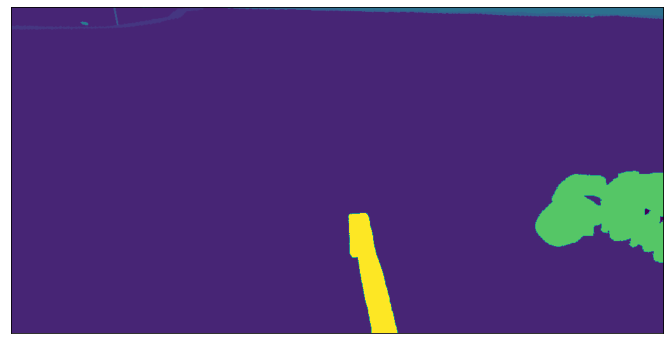

In [4]:
# check if vehicle and object lights overlap
# sub_df = df[(df.operation_time == 'daytime') & (df.state_y == 'true_positive')].sample(2)
sub_df = df.sample(2)
# image_ids = ['61c4303eec85fdd36b96116c', '61e27143c8f15657a286379e']
# sub_df = df[df.image_id.isin(image_ids)]
show_image, show_label, show_depth = True, True, False
compute_vehicle_head_light = False
if compute_vehicle_head_light:
    head_lights = []
    # dilate kernel
    kernel = np.ones((5, 5), np.uint8)
for i, row in sub_df.iterrows():
    if show_image:
        data_path = os.path.join(root_dir, row.stereo_pipeline_npz_save_path)
        stereo_data = np.load(data_path)
        img = stereo_data['left']
        img_norm = normalize_image(img, row.hdr_mode)
        print(row.image_id, row.operation_time, row.collected_on)
        plot_image(img_norm)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, row.rectified_label_save_path)
        lbl = np.load(label_path)['left']
        labels, counts = np.unique(lbl, return_counts=True)
        label_map = row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, row.label_counts, label_strs, labels, counts)
        plot_image(lbl)

        if compute_vehicle_head_light:
            label_map_reverse = {v:int(k) for k,v in json.loads(row.label_map).items()}
            vehicle_id, object_light_id = label_map_reverse['Tractors or Vehicles'], label_map_reverse['Object Lights']
            vehicle_mask = lbl == vehicle_id
            vehicle_mask = cv2.dilate(vehicle_mask.astype(np.uint8), kernel, iterations=3)
            object_light_mask = lbl == object_light_id
            object_light_mask = cv2.dilate(object_light_mask.astype(np.uint8), kernel, iterations=3)
            # print(vehicle_id, object_light_id, vehicle_mask.sum(), object_light_mask.sum())
            overlap = np.any(vehicle_mask & object_light_mask)
            if overlap:
                head_lights.append(row.id)
            # plot_image(vehicle_mask)
            # plot_image(object_light_mask)

# save head lights ids
if compute_vehicle_head_light:
    print(len(sub_df), len(head_lights))
    head_lights_df = pd.DataFrame(data={'id': head_lights})
    head_lights_df.to_csv('/data/jupiter/li.yu/data/Jupiter_train_v5_11/head_lights.csv', index=False)

In [128]:
def map_head_light_to_vehicle(gt_label, new_label, vehicle_id, object_light_id, vehicle_train_id):
    vehicle_mask = gt_label == vehicle_id
    rows, cols = np.where(vehicle_mask)
    min_row, max_row, min_col, max_col = np.min(rows), np.max(rows), np.min(cols), np.max(cols)
    H, W = gt_label.shape
    h, w = max_row - min_row + 1, max_col - min_col + 1
    pad_scale = 0.1
    h_pad, w_pad = int(h * pad_scale), int(w * pad_scale)
    min_row, max_row = max(0, min_row-h_pad), min(H, max_row+h_pad)
    min_col, max_col = max(0, min_col-w_pad), min(W, max_col+w_pad)
    object_light_in_vehicle_mask = gt_label[min_row:max_row, min_col:max_col] == object_light_id
    print(h, w, object_light_in_vehicle_mask.shape)
    if np.any(object_light_in_vehicle_mask):
        new_label[min_row:max_row, min_col:max_col][object_light_in_vehicle_mask] = vehicle_train_id
    return new_label

new_lbl = map_head_light_to_vehicle(lbl[:,:,0], lbl[:,:,0], 10, 27, 10)
vehicle_mask = new_lbl == vehicle_id
object_light_mask = new_lbl == object_light_id
print(vehicle_id, object_light_id, vehicle_mask.sum(), object_light_mask.sum())
# plot_image(vehicle_mask)
# plot_image(object_light_mask)

40 52 (47, 57)
10 27 1446 108


### Check HSV values and color conversion

In [5]:
# merge with HSV values
hsv_pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/v53_4cls_tversky001_imgaug_60p_0209'
rav1_datasets = ['Jupiter_train_v5_11']
halo_datasets = ['Jupiter_halo_labeled_data_20230427_stereo_640', 'Jupiter_halo_labeled_data_20230427_stereo_768']
rav1_hsv_df = pd.concat([pd.read_csv(os.path.join(hsv_pred_dir, d, 'output.csv')) for d in rav1_datasets], ignore_index=True)
halo_hsv_df = pd.concat([pd.read_csv(os.path.join(hsv_pred_dir, d, 'output.csv')) for d in halo_datasets], ignore_index=True)
rav1_hsv_df.shape, halo_hsv_df.shape

((319918, 17), (14102, 17))

In [10]:
# df = df.merge(rav1_hsv_df, on='id').drop_duplicates(subset=['id'])
df = df.merge(halo_hsv_df, on='id', how='inner').drop_duplicates(subset=['id'])
print(df.shape)

(4794, 198)


In [7]:
# sub_df = df[(df.Hue >= 200) & (df.Hue <= 250)].sample(1)
sub_df = df[df.operation_time == 'daytime'].sample(15)
# sub_df = df[df.id.isin(['5f9b32ae63d83fb102fb5eae','5f9dc49d1cbbf933eba9d1b2','5fa1e8103e3ed948a0a8b6f0','5fa59813b75d5f19999efa45','63d10d9ee296850f1d1bb608'])]
# image_id = '6441f403242be814b7adeb3d'
# sub_df = df[df.image_id == image_id]
plot_image, plot_label = False, False
save_image, save_label = True, True
save_image_dir = os.path.join(hsv_pred_dir, 'rev1_samples')
# save_image_dir = os.path.join(hsv_pred_dir, 'halo_samples')
os.makedirs(save_image_dir, exist_ok=True)
for i, row in sub_df.iterrows():
    data_path = os.path.join(root_dir, 'processed/images', row.image_id, 'stereo_output.npz')
    img = np.load(data_path)['left']
    img_norm = normalize_image(img, row.hdr_mode)
    if plot_image:
        print(row.image_id, row.operation_time, row.collected_on)
        # print([img_norm.dtype, img_norm.min(), img_norm.max()], np.mean(cv2.cvtColor(img_norm, cv2.COLOR_RGB2HSV), axis=(0,1)))
        plot_image(img_norm)
    if save_image:
        save_image_path = os.path.join(save_image_dir, row.id+'.png')
        cv2.imwrite(save_image_path, cv2.cvtColor((img_norm * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    if 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, row.rectified_label_save_path)
        lbl = np.load(label_path)['left']
        print(row.image_id, np.unique(lbl))
        if plot_label:
            plot_image(lbl)
        if save_label:
            save_label_path = os.path.join(save_image_dir, row.id+'_label.png')
            cv2.imwrite(save_label_path, lbl)

5f5fff24fe8915f92e712bbf [ 0  2 11 14 15 19]
628115956bc8eb8409f17f40 [ 2 14 19]
627dcf576c49686d209e9d41 [2 6 7]
5fa7f408f3341d2df1e071d8 [ 0  2  5  6  7 10 11 14]
61b0635a16fe7dae0cb31f65 [ 2  6  7  8 24]
5f5acf662aa7f779740f7027 [2]
611acbdececadc422e18a30b [ 0  2 14 15 16]
616f8addbeecc0b847117b9d [ 0  1  2  6  7  8 14 22]
63d04f6a65c67d2a26395b56 [2 5 6 7 8]
5f9cd30a69417fd02e1bdaaa [ 0  2  6  7 10 14 15 16 17 18 20]
638ac94156c7a0791a60404f [2 6 7 8]
6394db5c656423c4bc9a8860 [2 4 5 6 7]
614ecaf77585e5bf21220150 [ 0  2  4  6  7  8 11 14 18]
620c700704c8e22029a3288a [ 0 11]
61c4c37da11c7feb825a6e3a [ 0  2 11 14 19]


[dtype('float32'), 0.0, 255841.0]
[dtype('float32'), 0.0, 1.0] [214.55406     0.2515261   0.6425207]


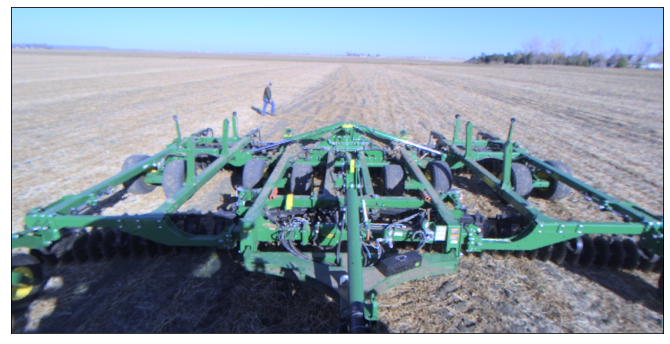

In [62]:
normalization_parameters = {"policy": "tonemap", "alpha": 0.25, "beta": 0.9, "gamma": 0.85, "eps": 1e-6}
img_norm = normalize_image(img, row.hdr_mode, normalization_parameters)
print([img.dtype, img.min(), img.max()])
print([img_norm.dtype, img_norm.min(), img_norm.max()], np.mean(cv2.cvtColor(img_norm, cv2.COLOR_RGB2HSV), axis=(0,1)))
plot_image(img_norm)

[102.94739      0.25226712   0.64059645]
[103.0137       0.35896483   0.6554958 ]


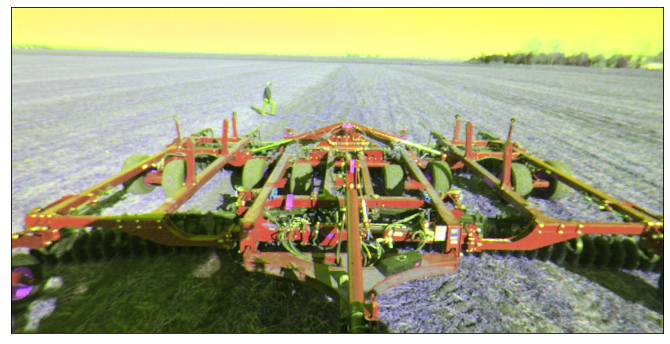

In [76]:
import torchvision.transforms.functional as F
from PIL import Image
img2 = F.adjust_hue(Image.fromarray((img_norm * 255).astype(np.uint8)), hue_factor=-0.4)
print(np.mean(cv2.cvtColor((np.array(img2)/255).astype(np.float32), cv2.COLOR_RGB2HSV), axis=(0,1)))
# plot_image(img2)
img3 = F.adjust_saturation(img2, saturation_factor=1.5)
print(np.mean(cv2.cvtColor((np.array(img3)/255).astype(np.float32), cv2.COLOR_RGB2HSV), axis=(0,1)))
plot_image(img3)

### Check color transfer target folders

In [6]:
root_dir = '/data/jupiter/datasets'
datasets = ['Jupiter_halo_labeled_data_20230502_train_stereo_640_768',
            'Jupiter_halo_labeled_data_20230510_train_stereo_640_768_single_ds',
            'Jupiter_halo_labeled_data_20230512_train_stereo_640_768_single_ds']
dfs = []
ids_list = []
for d in datasets:
    df = pd.read_csv(os.path.join(root_dir, d, 'master_annotations.csv')).drop_duplicates(subset="id")
    ids = os.listdir(os.path.join(root_dir, d))
    print(len(df), len(ids), ids)
    dfs.append(df)
    ids_list.append(ids)

12469 3 ['master_annotations.csv', 'processed', 'master_annotations_cutnpaste.csv']
20836 2 ['processed', 'master_annotations.csv']
19181 5 ['master_annotations.csv', 'master_annotations_factorycal_flagged_dropped.csv', 'master_annotations_768.csv', 'processed', 'master_annotations_640.csv']


In [20]:
dfs[1].merge(dfs[2], on='id').drop_duplicates(subset="id").shape

(15210, 522)

In [38]:
for i in range(3):
    print(dfs[i].iloc[0].stereo_pipeline_npz_save_path)

processed/images_640/6441f35314e09b723389bb3e/stereo_output.npz
processed/images/64549e2c3d4b212874e91fcf/stereo_output_T14_T16.npz
processed/images/6441ee2353d575317036dee1/stereo_output_T05_T07.npz


In [27]:
ids = os.listdir(os.path.join(root_dir, datasets[1], 'processed/images'))
len(ids)

9832

In [35]:
dfs[1][dfs[1].id == '6447159450cd8646eb376e61'].iloc[0].stereo_pipeline_npz_save_path

'processed/images/6447159450cd8646eb376e61/stereo_output_T09_T11.npz'

In [42]:
right_ids = []
for i,row in dfs[0].iterrows():
    if os.path.isfile(os.path.join(root_dir, datasets[0], row.stereo_pipeline_npz_save_path)):
        right_ids.append(row.id)
dfs[0].shape, len(right_ids)

((12469, 184), 12469)

In [40]:
df1 = dfs[1][dfs[1].id.isin(right_ids)]
print(df1.shape)
df1.to_csv(os.path.join(root_dir, datasets[1], 'master_annotations_stereo_valid.csv'), index=False)

(9831, 185)


In [44]:
df1.stereo_pipeline_npz_save_path = df1.stereo_pipeline_npz_save_path.apply(lambda p: os.path.join(root_dir, datasets[1], p))
df1.iloc[0].stereo_pipeline_npz_save_path

/home/li.yu/anaconda3/envs/shank/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


'/data/jupiter/datasets/Jupiter_halo_labeled_data_20230510_train_stereo_640_768_single_ds/processed/images/64549e2c3d4b212874e91fcf/stereo_output_T14_T16.npz'

In [63]:
target_dir = [
    '/data/jupiter/datasets/Jupiter_halo_labeled_data_20230502_train_stereo_640_768',
    '/data/jupiter/datasets/Jupiter_halo_labeled_data_20230510_train_stereo_640_768_single_ds',
    '/data/jupiter/datasets/Jupiter_halo_labeled_data_20230512_train_stereo_640_768_single_ds'
    ]
target_csv = [
    '/data/jupiter/datasets/Jupiter_halo_labeled_data_20230502_train_stereo_640_768/master_annotations.csv',
    '/data/jupiter/datasets/Jupiter_halo_labeled_data_20230510_train_stereo_640_768_single_ds/master_annotations_stereo_valid.csv',
    '/data/jupiter/datasets/Jupiter_halo_labeled_data_20230512_train_stereo_640_768_single_ds/master_annotations.csv'
    ]
target_dfs = []
for d, c in zip(target_dir, target_csv):
    df = pd.read_csv(c, low_memory=False).drop_duplicates(subset="id")
    df.stereo_pipeline_npz_save_path = df.stereo_pipeline_npz_save_path.apply(lambda p: os.path.join(d, p))
    target_dfs.append(df)
target_df = pd.concat(target_dfs, ignore_index=True).drop_duplicates(subset="id")
target_df.shape

(22896, 341)

In [68]:
# target_df['index'] = target_df.reset_index().index
target_df['row_idx'] = np.arange(len(target_df))

In [71]:
target_df.row_idx

0            0
1            1
2            2
3            3
4            4
         ...  
41470    22891
41474    22892
41477    22893
41478    22894
41479    22895
Name: row_idx, Length: 22896, dtype: int64

In [72]:
target_df.iloc[22894][['index', 'row_idx']]

index      22894
row_idx    22894
Name: 41478, dtype: object

In [2]:
color_transfer_dir = '/data/jupiter/datasets/Jupiter_train_v5_11/processed_color_transfer/images/'
files = os.listdir(color_transfer_dir)
len(files)

317385

In [4]:
samples = random.choices(files, k=5)
# samples = bad_ids
samples

['63c7517473065a6372def94a',
 '5f4859bed8925e8622ee7ea7',
 '6403522a056822cf0cbb0e7e',
 '61c2a3cc7d515cfa970bb975',
 '5f35e137fb37fa684ce89705',
 '6389868ce9153c8a7da36a9a']

In [7]:
for s in samples:
    f = os.listdir(os.path.join(color_transfer_dir, s))[0]
    d = np.load(os.path.join(color_transfer_dir, s, f), allow_pickle=True)
    print(d.files)
    img = d[np.random.choice(d['target_ids'], 1)[0]]
    print(d['depth'].shape, img.shape)
    plt.imshow(img)
    plt.show()

BadZipFile: File is not a zip file

In [3]:
# mdf = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v5_11/trainrd05_color_transfer.csv')
# mdf = pd.read_csv('/data/jupiter/datasets/Jupiter_halo_labeled_data_20230512_train_stereo_640_768_single_ds/master_annotations.csv')
mdf = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v5_11/halo0512_orisize_humanaug.csv')
mdf.shape

(25279, 29)

In [16]:
data_dir = '/data/jupiter/datasets/Jupiter_halo_labeled_data_20230512_train_stereo_640_768_single_ds'
sdf = mdf.sample(5)
for i,row in sdf.iterrows():
    stereo_data_sample = np.load(
        os.path.join(data_dir, row.stereo_pipeline_npz_save_path)
    )
    image = stereo_data_sample['left']
    label = np.load(
        os.path.join(data_dir, row.rectified_label_save_path)
    )
    label = label['left'][..., 0]
    print(row.id, image.shape, label.shape)

645b71f424275c2badd78da2 (512, 768, 3) (512, 768)
64475b1ea381503eba3b5158 (512, 768, 3) (512, 768)
6441f2a65a56c114e77147e3 (512, 640, 3) (512, 640)
6441f128242be814b7ade1b8 (512, 768, 3) (512, 768)
644722abe8a8e03f8830d532 (512, 768, 3) (512, 768)


In [17]:
'rectified_stereo_output_height' in mdf

True

### Save sample images

In [3]:
cls4_pred_root = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
train_id = 'v206_510r_rak_local_strong_alb_fine_8cls_tversky11_prod_w002p001d035_r3a8_s30'
dataset = 'Jupiter_2023_03_29_10pm_30_3pm_Loamy_812_stops_stereo_2'
cls4_pred = os.path.join(cls4_pred_root, train_id)
cls4_df = pd.read_csv(os.path.join(cls4_pred, dataset, 'output.csv'))
print(cls4_df.shape)

# dust detection
cls4_dust_df = pd.read_csv(os.path.join(cls4_pred, dataset, 'dust_ratio.csv'))
# merge seg df and dust df
cls4_df = cls4_df.merge(cls4_dust_df, on='id')
print(cls4_df.shape)

# merge with master df to get collected_on
mdf = pd.read_csv(f'/data/jupiter/li.yu/data/{dataset}/master_annotations.csv')
mdf = mdf[['id', 'collected_on', 'hdr_mode', 'stereo_pipeline_npz_save_path']].drop_duplicates(subset=['id'])
print('total master df', mdf.shape)
cls4_df = cls4_df.merge(mdf, on='id').drop_duplicates(subset=['id'])
print('merge master df', cls4_df.shape)

ldf = pd.read_csv(os.path.join(cls4_pred, dataset, 'output.csv'))
ldf = ldf[['id', 'state']]
cls4_df = cls4_df.drop('state', axis=1)
cls4_df = cls4_df.merge(ldf, on='id', how='left').drop_duplicates(subset=['id'])
cls4_df = cls4_df.fillna('true_negative')
cls4_df = cls4_df.replace('large_object_true_positive', 'true_positive')
cls4_df = cls4_df.replace('large_object_false_negative', 'false_negative')
# cls4_df = cls4_df.sort_values('collected_on')
print('merge labeled states', cls4_df.shape)
cls4_df.shape


(36206, 7)
(36206, 15)


/home/li.yu/anaconda3/envs/shank/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3134: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


total master df (36206, 4)
merge master df (36206, 18)
merge labeled states (36206, 18)


(36206, 18)

In [4]:
cls4_df.head()

,id,camera_location,operation_time,human_state,vehicle_state,min_pixels_threshold,gt_dust_ratio,pred_dust_ratio,total_averaged_dust_ratio,total_thresholded_dust_ratio,triangle_averaged_dust_ratio,triangle_thresholded_dust_ratio,human_in_triangles_pixels,human_aspect_ratio,collected_on,hdr_mode,stereo_pipeline_npz_save_path,state
0,642709f11620247e22867865,front-left-left,daytime,true_negative,true_negative,400,0.0,0.0,0.001232,0.0,0.001399,0.0,0,true_negative,2023-03-30T14:50:00.057000,True,processed/images/642709f11620247e22867865/ster...,true_negative
1,642709efd7aeccaff79f762e,front-right-left,daytime,true_negative,true_negative,400,0.0,0.0,0.000084,0.0,0.000011,0.0,0,true_negative,2023-03-30T14:50:00.040000,True,processed/images/642709efd7aeccaff79f762e/ster...,true_negative
2,642709f061245ce0ea86f9a7,front-center-left,daytime,true_negative,true_negative,400,0.0,0.0,0.000104,0.0,0.000078,0.0,0,true_negative,2023-03-30T14:50:00.059000,True,processed/images/642709f061245ce0ea86f9a7/ster...,true_negative
3,6425bf80fb0cfb5575aa0e2e,front-left-left,daytime,true_negative,true_negative,400,0.0,0.0,0.001516,0.0,0.000070,0.0,0,true_negative,2023-03-29T23:45:43.216000,True,processed/images/6425bf80fb0cfb5575aa0e2e/ster...,true_negative
4,6425bf81afb870a21b5257ec,front-center-left,daytime,true_negative,true_negative,400,0.0,0.0,0.000038,0.0,0.000010,0.0,0,true_negative,2023-03-29T23:45:43.215000,True,processed/images/6425bf81afb870a21b5257ec/ster...,true_negative


In [5]:
save_dir = f'/data/jupiter/li.yu/data/{dataset}/sample_images'
os.makedirs(save_dir, exist_ok=True)
sub_df = cls4_df[cls4_df.pred_dust_ratio > 0.2]
print(sub_df.shape)
for i,row in sub_df.sample(5).iterrows():
    data_path = os.path.join(f'/data/jupiter/li.yu/data/{dataset}', row.stereo_pipeline_npz_save_path)
    img = np.load(data_path)['left']
    img = normalize_image(img, row.hdr_mode)
    # plot_image(img)
    cv2.imwrite(os.path.join(save_dir, row.id+'.png'), (img*255).astype(np.uint8))

(6981, 18)


### Create dataset with left and right image labels

In [3]:
# root_dir = '/data/jupiter/li.yu/data'
# stereo_dir = f'{root_dir}/left_and_right_labels_samples/'
# left_dir = f'{root_dir}/left_and_right_labels_samples_only_left/'
# right_dir = f'{root_dir}/left_and_right_labels_samples_only_right/'
root_dir = '/data/jupiter/datasets'
stereo_dir = f'{root_dir}/20230823_labeled_right_images_12k/'
left_dir = f'{root_dir}/20230823_labeled_right_images_12k_left_images_labels/'
right_dir = f'{root_dir}/20230823_labeled_right_images_12k_right_images_labels/'
stereo_df = pd.read_csv(os.path.join(stereo_dir, 'annotations.csv'))
main_df = pd.read_csv(os.path.join(stereo_dir, 'master_annotations.csv'))

left_label_df = pd.read_csv(f'{left_dir}/master_annotations.csv')
right_label_df = pd.read_csv(f'{right_dir}/master_annotations.csv')

stereo_df.shape, main_df.shape, left_label_df.shape, right_label_df.shape

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (21,23,65,66,67,68,70,71,72,73,74,75,76,77,78,83,89,92,100,102,118,123,125,128,130,136,137,145,146,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,169,171,172,173,174,175,176,177,178,180,182,186,196,204,206,209,218) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (108,123,128,133,135,185,215,244) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (118,123,128,130,180,209) have mixed types.Specify dtype option on import or set low_

((24332, 219), (12141, 267), (12166, 248), (12166, 237))

In [17]:
# read and save right label to left label npz file
for i,row in main_df.iterrows():
    left_id = row.id
    left_camera = row.camera_location
    left_camera = left_camera[:-5] if left_camera.endswith('left') else left_camera[:-6]
    # remove existing files
    stereo_label_path = os.path.join(stereo_dir, row.rectified_label_save_path)
    if os.path.isfile(stereo_label_path):
        os.remove(stereo_label_path)
    # read left label
    row = left_label_df[left_label_df.id == left_id].iloc[0]
    left_label_path = os.path.join(left_dir, row.rectified_label_save_path)
    left_label = np.load(left_label_path)['left']
    # read right label
    group_id = stereo_df[stereo_df.id == left_id].iloc[0].group_id
    right_id = stereo_df[(stereo_df.group_id == group_id) & (stereo_df.id != left_id) & (stereo_df.camera_location.str.startswith(left_camera))].iloc[0].id
    row = right_label_df[right_label_df.id == right_id].iloc[0]
    right_label_path = os.path.join(right_dir, row.rectified_label_save_path)
    right_label = np.load(right_label_path)['left']
    # save both labels to a file
    np.savez_compressed(stereo_label_path, **{'left': left_label, 'right': right_label})

61a6956d7d0b9620740fcd49 [ 2  4  5  6  7  8  9 11 24]
61a6956d7d0b9620740fcd49 [ 2  4  5  6  7  9 11]


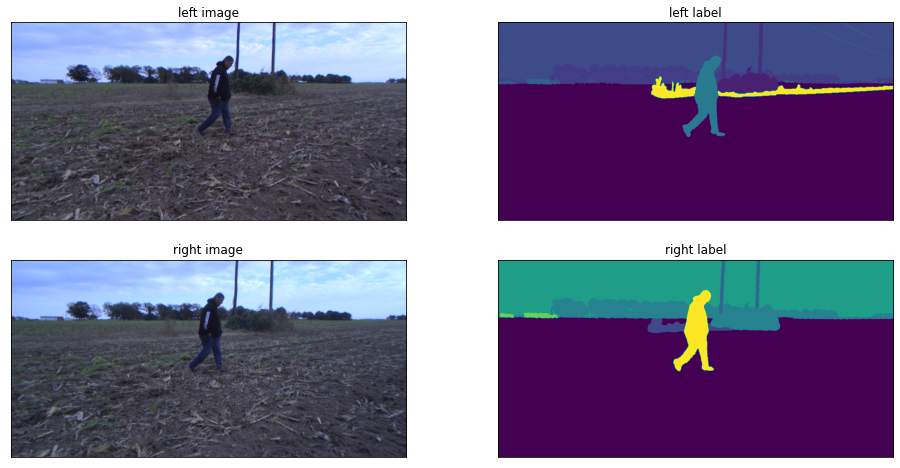

616fc4c45199b6d403637fad [ 2  5  6  7  8 11 27]
616fc4c45199b6d403637fad [ 0  2  6  7  8 11]


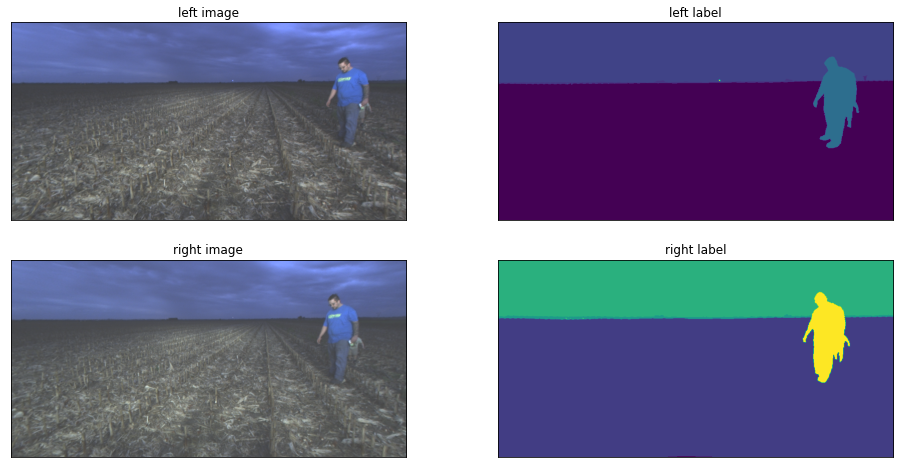

In [19]:
# image_id = '614ebedfdd517b17f67e8f65'
# sample_df = df[df.image_id == image_id]
sample_df = main_df.sample(2)
for i, row in sample_df.iterrows():
    if 'stereo_pipeline_npz_save_path' in row:
        data_path = os.path.join(stereo_dir, row.stereo_pipeline_npz_save_path)
        data = np.load(data_path)
        left_img = data['left']
        left_img = normalize_image(left_img, row.hdr_mode)
        # plot_image(left_img)
        right_img = data['right']
        right_img = normalize_image(right_img, row.hdr_mode)
        # plot_image(right_img)
    
    # # read labels from mono datasets
    # row = left_label_df[left_label_df.id == row.id].iloc[0]
    # if 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
    #     label_path = os.path.join(left_dir, row.rectified_label_save_path)
    #     left_lbl = np.load(label_path)['left']
    #     print(row.image_id, np.unique(left_lbl))
    #     # plot_image(left_lbl)
    # group_id = stereo_df[stereo_df.id == row.id].iloc[0].group_id
    # right_id = stereo_df[(stereo_df.group_id == group_id) & (stereo_df.id != row.id)].iloc[0].id
    # row = right_label_df[right_label_df.id == right_id].iloc[0]
    # if 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
    #     label_path = os.path.join(right_dir, row.rectified_label_save_path)
    #     right_lbl = np.load(label_path)['left']
    #     print(row.image_id, np.unique(right_lbl))
    #     # plot_image(right_lbl)

    # read labels from updated stereo dataset folder
    if 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(stereo_dir, row.rectified_label_save_path)
        data = np.load(label_path)
        left_lbl = data['left']
        print(row.image_id, np.unique(left_lbl))
        # plot_image(left_lbl)
        right_lbl = data['right']
        print(row.image_id, np.unique(right_lbl))
        # plot_image(right_lbl)

    plot_images([left_img, left_lbl, right_img, right_lbl], 2, 2, ['left image', 'left label', 'right image', 'right label'])